# Mobility of particles

The Mean Square Displacement (MSD) is a quantitative metric of system dynamics, particularly in the context of simulated data. The MSD is defined as:
\begin{equation*}
\text{MSD}(t) = \frac{1}{N_{\text{particles}}} \sum_{i=1}^{N_{\text{particles}}} \left[ \frac{1}{N-t} \sum_{k=0}^{N-t-1} \left( \vec{r}_i(k+t) - \vec{r}_i(k) \right)^2 \right]
\end{equation*}
Here, $\vec{r}_i(k)$ represents the position vector of particle $i$ at time step $k$, and $t$ denotes the time interval over which the displacement is measured. $N$ is the total number of time steps, and $N_{\text{particles}}$ is the number of particles in the system. The MSD effectively captures the rate at which molecules explore their spatial environment. For calculation of MSD we employed the freud Python package and saved data into csv format.

In [7]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.colors as mcolors
import pandas as pd
import pickle

In [2]:
# load the data
msd = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/rigid/msd.csv', index_col=0)
msd_k1 = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k1/msd.csv', index_col=0)
msd_k2 = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k2/msd.csv', index_col=0)
msd_k10 = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k10/msd.csv', index_col=0)
msd_k100 = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k100/msd.csv', index_col=0)
msd_k1000 = pd.read_csv('/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k1000/msd.csv', index_col=0)

In [20]:
D_coeff = {}
D_coeff_k1 = {}
D_coeff_k2 = {}
D_coeff_k10 = {}
D_coeff_k100 = {}
D_coeff_k1000 = {}

In glasses, the MSD reflects characteristics of both liquids and crystals, exhibiting three distinct regimes. Initially, at short timescale, particles exhibit ballistic motion, where MSD is proportional to $t^2$. Then, at intermediate timescale, a plateau emerges, indicative of solid-like behavior where particle movement is constrained by neighboring particles. Finally, at long timescale, particles overcome these constraints, leading to Brownian motion similar to that in liquids, but also slower with lower diffusion coefficient.

Dependence of MSD on time in 3-dimensional system is described through diffusion coefficient $D$:
\begin{equation*}
\text{MSD} = 6Dt
\end{equation*}

In [9]:
def diff(t, D):
    return 6*D*t

rigid model for different temperatures

Text(5000000.0, 1000, '$6Dt$')

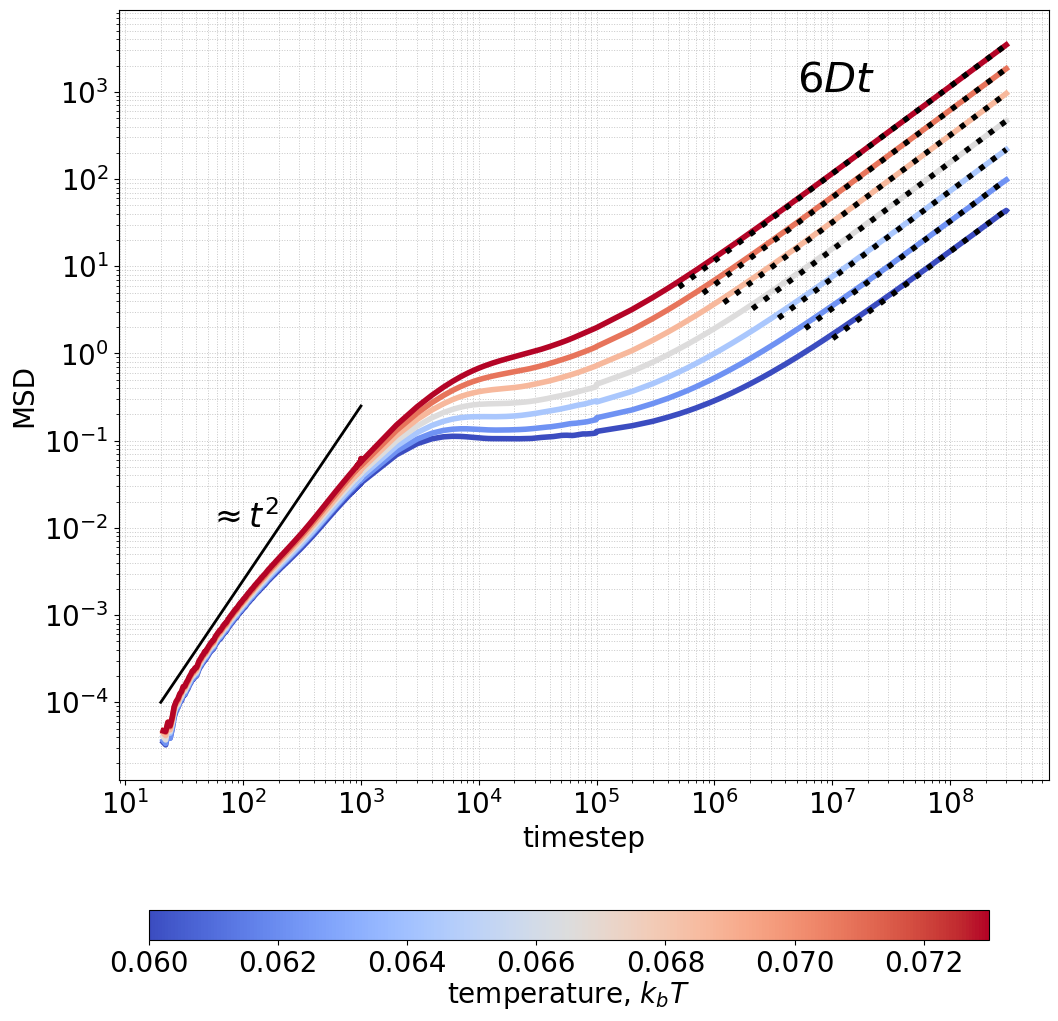

In [21]:
# create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (12,10))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.loglog()
plt.xlabel('timestep')
plt.ylabel('MSD')

# create a colorbar
colors = [mpl.cm.coolwarm(i) for i in np.linspace(0, 1, 13)]
norm = mpl.colors.Normalize(vmin=0.06, vmax=0.073)
sm = mpl.pyplot.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar_ax = f.add_axes([0.15, -0.05, 0.7, 0.03]) 
cbar = f.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'temperature, $k_bT$', rotation=0, labelpad=1)


for i in range(7): # loop over temperatures
    kT = str(np.round(0.06 + i*0.002, 3))

    #plot the msd data, don't plot the first 20 points
    #x*1000, because dt = 0.001
    axs.plot(np.array((msd.index)[20:])*1000, list(msd[kT])[20:], c=colors[i*2], linewidth=4)

    #fit the diffusive regime
    #the start of fitting defines as 10000/1.7**i, because the diffusive regime starts later for lower temperatures
    x  = msd[msd.index>(10000/1.7**i)].index
    y  = msd[msd.index>(10000/1.7**i)][kT]
    D, err = curve_fit(diff, x, y)
    D_coeff[kT] = (D, err)
    axs.plot(x*1000, diff(x, D), color='k', linestyle=':', linewidth=4)

# plot the characteristic line for ballistic motion
t = np.linspace(20, 1000)
axs.plot(t, t*t/4000000, color='k', linestyle='-', linewidth=2)
axs.annotate(r'$\approx t^2$', xy=(50, 0.01), rotation=0, color='k', fontsize=24)

axs.annotate(r'$6Dt$', xy=(0.5*10**7, 10**(3)), rotation=0, color='k', fontsize=30)

The diffusion coefficient $D$ characterizes the dynamics of materials at long timescale. As temperature increases, the diffusion coefficient $D$ rises, reflecting enhanced molecular mobility due to thermally activated dynamics. This relationship is quantitatively described by the Arrhenius equation:
\begin{equation*}
D = D_0 \exp\left(-\frac{E_a}{k_bT}\right),
\end{equation*}
where $E_a$ is the activation energy. In the context of glass materials, the Arrhenius equation is applicable to so-called strong glass formers, as opposed to fragile glasses. The activation energy $E_a$ represents the minimum energy that particles must acquire to effectively diffuse out of the potential energy barriers formed by their neighboring particles.  This activation energy is a fundamental descriptor of molecular transport within the material and can be further used to compare different systems with each other.

Slope: -1.5778159458853827, Intercept: 15.653367854196231
Correlation Coefficient: -0.9999463255750799
P-value: 4.0537769804087295e-11 (Statistical significance)
Standard Error: 0.007311180734990572


/tmp/ipykernel_2366021/506736824.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = np.array([float(k[0]) for k in D_coeff.values()]) #D coefficient, k[1] would be the error


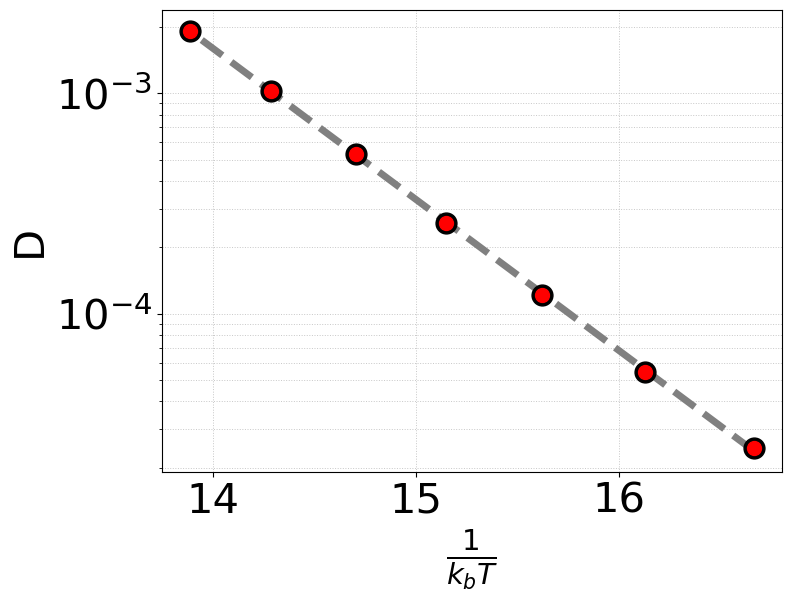

In [29]:
# create a figure 
mpl.rcParams['font.size'] = 30
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$\frac{1}{k_bT}$')
plt.ylabel(r'D')
plt.yscale('log')

# extract data
x = 1 / np.array([float(k) for k in D_coeff.keys()]) #reverse temperature
y = np.array([float(k[0]) for k in D_coeff.values()]) #D coefficient, k[1] would be the error

# fit the data
slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))
print(f"Slope: {slope}, Intercept: {intercept}")
print(f"Correlation Coefficient: {r_value}")
print(f"P-value: {p_value} (Statistical significance)")
print(f"Standard Error: {std_err}")
# Plot the linear fit
plt.plot(x, np.exp(slope * x + intercept), linestyle='--', color='grey', linewidth=5)

#plot thre data
plt.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=15, color='k')
plt.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=10, color='red')

In [16]:
# open files
file_paths = [
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/rigid/pairs_8_5.pkl',
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k1/pairs_8_5.pkl',
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k2/pairs_8_5.pkl',
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k10/pairs_8_5.pkl',
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k100/pairs_8_5.pkl',
    '/share/scratch1/alena.taskina01/md/hoomd4/3patches/angles/k1000/pairs_8_5.pkl'
]

variables = ['pairs', 'pairs_k1', 'pairs_k2', 'pairs_k10', 'pairs_k100', 'pairs_k1000']

for file_path, variable in zip(file_paths, variables):
    with open(file_path, 'rb') as file:
        globals()[variable] = pickle.load(file)

$D$ is proportional to the concentration of non-bonded particles, defined by the expression $(1-p_b)^3$

Slope: 0.4884681383168361, Intercept: -1.3652244637514088e-05
Correlation Coefficient: 0.9994543281715268
P-value: 1.3355363280640822e-08 (Statistical significance)
Standard Error: 0.0072195444783018665


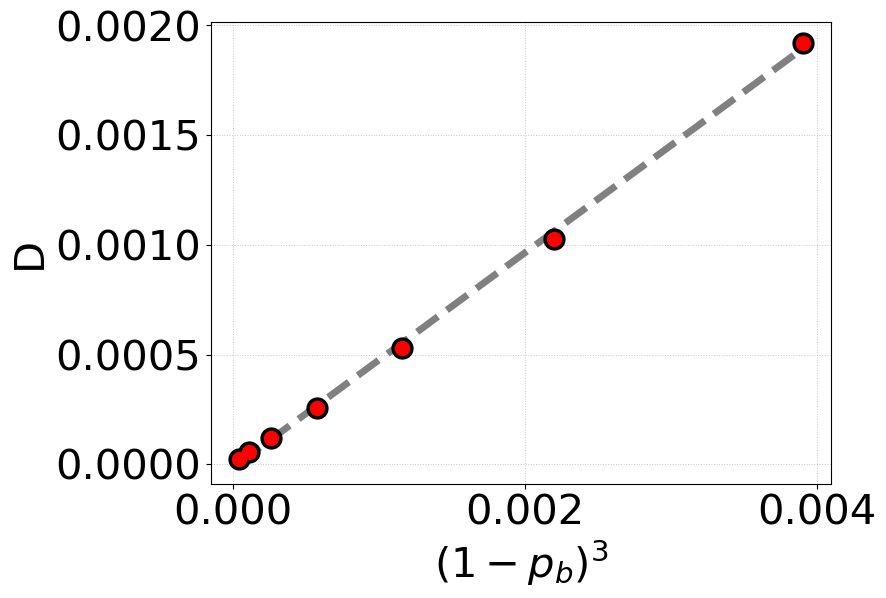

In [31]:
# create a figure
mpl.rcParams['font.size'] = 30
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$(1-p_b)^3$')
plt.ylabel(r'D')

# extract data
N=10648
kTs = [np.round(0.06+i*0.002,3) for i in range(7)]
x = np.array([(np.mean(pairs[kT][0]/(N*3)))**3 for kT in kTs]) # (1-p_b)^3, where p_b is the bond probability; fraction of free particles in the system
y = np.array([D_coeff[str(kT)][0][0] for kT in kTs]) # D coefficient

#fit the data
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"Slope: {slope}, Intercept: {intercept}")
print(f"Correlation Coefficient: {r_value}")
print(f"P-value: {p_value} (Statistical significance)")
print(f"Standard Error: {std_err}")
plt.plot(x, slope * x + intercept, linestyle='--', color='grey', linewidth=5)

# plot the data
plt.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=15, color='k')
plt.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=10, color='red')


flexible model at $k_bT=0.06$

In [45]:
Ds = [D_coeff, D_coeff_k1, D_coeff_k2, D_coeff_k10, D_coeff_k100, D_coeff_k1000]
msd_data = [msd, msd_k1, msd_k2, msd_k10, msd_k100, msd_k1000]

/tmp/ipykernel_2366021/287635148.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


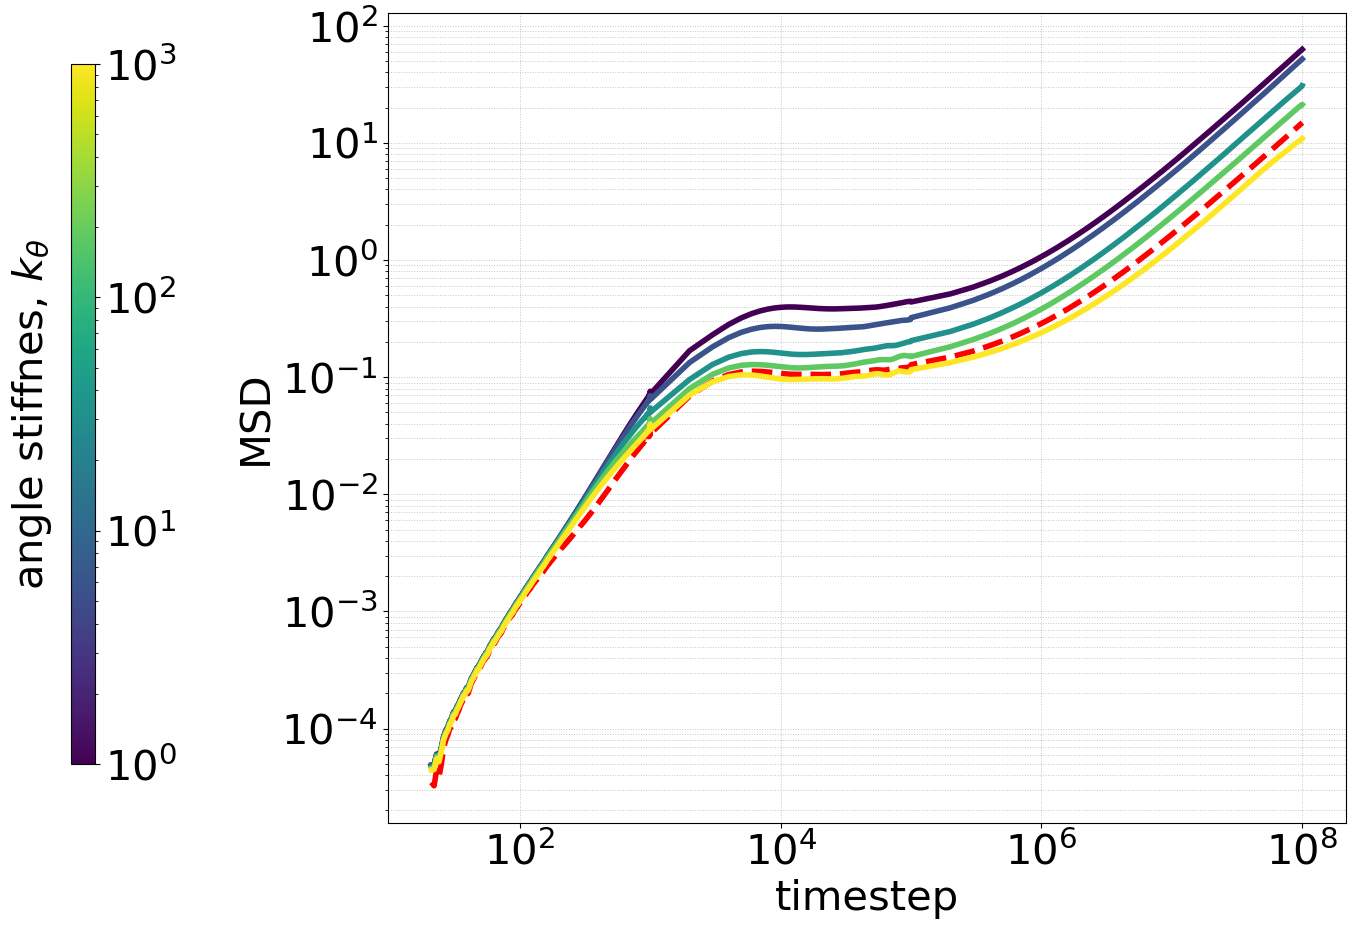

In [44]:
# create a figure 
mpl.rcParams['font.size'] = 30
f, axs = plt.subplots(1, 1, figsize = (12,10))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.loglog()
plt.xlabel('timestep')
plt.ylabel('MSD')

# create a colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = f.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = f.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-120)

kT = '0.06'
# plot ridig model
axs.plot(np.array((msd.index)[20:2100])*1000, list(msd[kT])[20:2100], c='r', linewidth=4, linestyle='--', label='rigid model')

#plot the flexible models
for j in range(1,6):
    axs.plot(np.array((msd_data[j].index)[20:])*1000, list(msd_data[j][kT])[20:], c=colors[j-1], linewidth=4)

f.tight_layout()

/tmp/ipykernel_2366021/4276162893.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


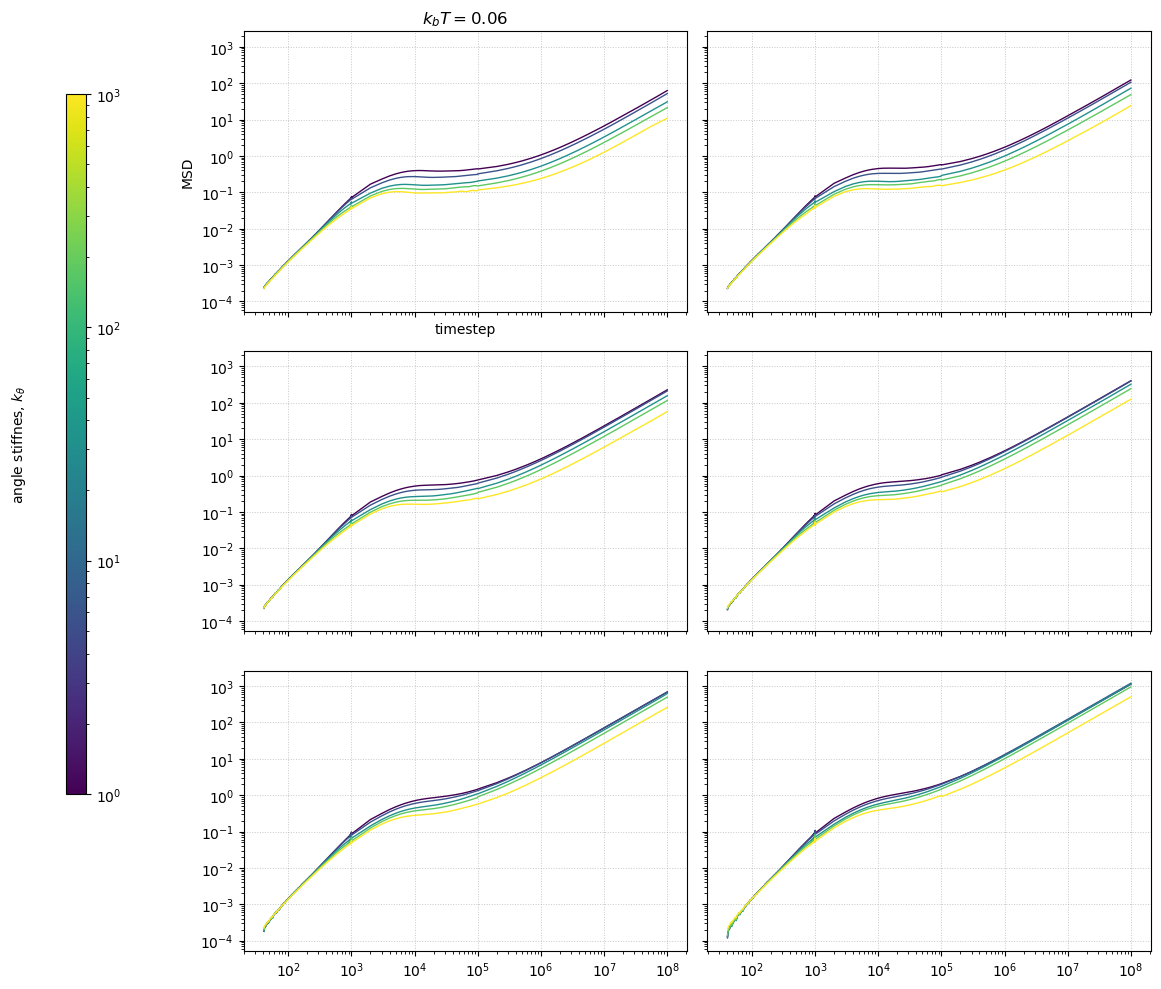

In [47]:
#create a figure
mpl.rcParams['font.size'] = 10
f, axs = plt.subplots(3, 2, figsize = (10,10), sharex=True, sharey=True)
axs_list = axs.flatten()
for ax in axs_list:
    ax.grid(True, which='major', linestyle=':', linewidth=0.7, alpha=0.7)

# create a colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = f.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = f.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-80)

for j in range(1,6): # loop over angle stiffness
    for i in range(6): # loop over temperatures
        kT = str(np.round(0.06 + i*0.002, 3))

        # plot the msd data, don't plot the first 20 points
        axs_list[i].plot(np.array((msd_data[j].index)[40:])*1000, list(msd_data[j][kT])[40:], c=colors[j-1], linewidth=1)
        if i==0:
            axs_list[i].loglog()
            axs_list[i].set_xlabel('timestep')
            axs_list[i].set_ylabel('MSD')
            axs_list[i].set_title(r'$k_bT=$'+kT)

        # fit the diffusive regime and save the D coefficient
        x  = msd_data[j][msd_data[j].index>(10000/1.7**i)].index
        y  = msd_data[j][msd_data[j].index>(10000/1.7**i)][kT]
        D = curve_fit(diff, x, y)[0][0]
        Ds[j][kT] = D

f.tight_layout()

3.705052961726152e-09
8.24289187464001e-09
3.091668558595286e-08
2.454327506390981e-08
1.5659882226643395e-07
4.0537769804087295e-11


/tmp/ipykernel_2366021/3439506158.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


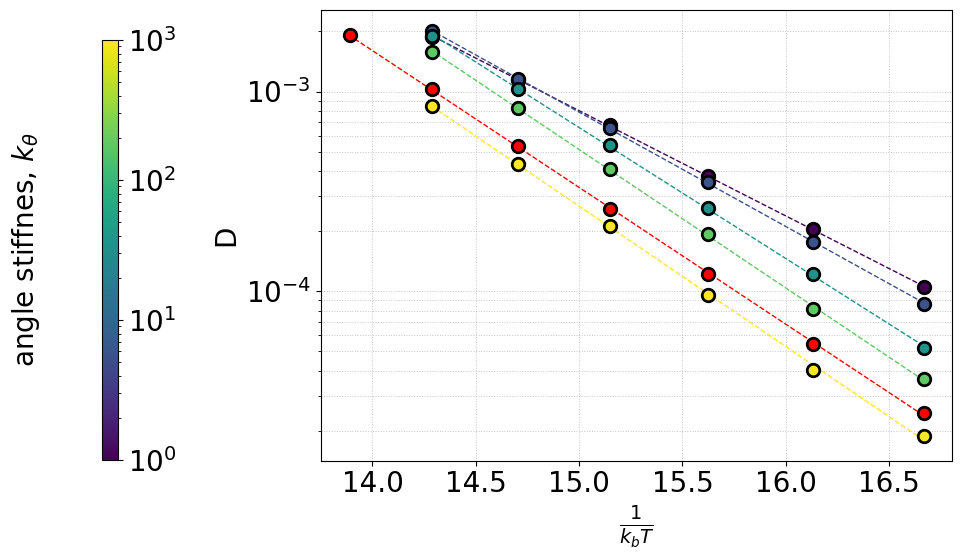

In [55]:
# create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$\frac{1}{k_bT}$')
plt.ylabel(r'D')
plt.yscale('log')

# create a colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = f.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = f.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-120)

# for flexible model
slopes = []
errors = []
N=10648
kTs = np.array([np.round(0.06+i*0.002,3) for i in range(6)])
x = 1/kTs
for j in range(5): # loop over angle stiffness
    y = np.array([Ds[j+1][str(kT)] for kT in kTs])

    #fit the data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))
    slopes.append(slope)
    errors.append(std_err)
    print(p_value)
    axs.plot(x, np.exp(slope * x + intercept), linestyle='--', color=colors[j], linewidth=1)
    # plot the data
    axs.plot(x, y, 'o', label=r'$k_\theta=1$', color='k', markersize=10)
    axs.plot(x, y, 'o', label=r'$k_\theta=1$', color=colors[j], markersize=6)

# for rigid model
kTs = [np.round(0.06+i*0.002,3) for i in range(7)]
x = 1/np.array(kTs)
y = np.array([D_coeff[str(kT)][0][0] for kT in kTs])
#fit the data
slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))
print(p_value)
axs.plot(x, np.exp(slope * x + intercept), linestyle='--', color='red', linewidth=1)
# plot the data
axs.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=10, color='k')
axs.plot(x, y, 'o', label=r'$k_\theta=inf$', markersize=6, color='red')

f.tight_layout()

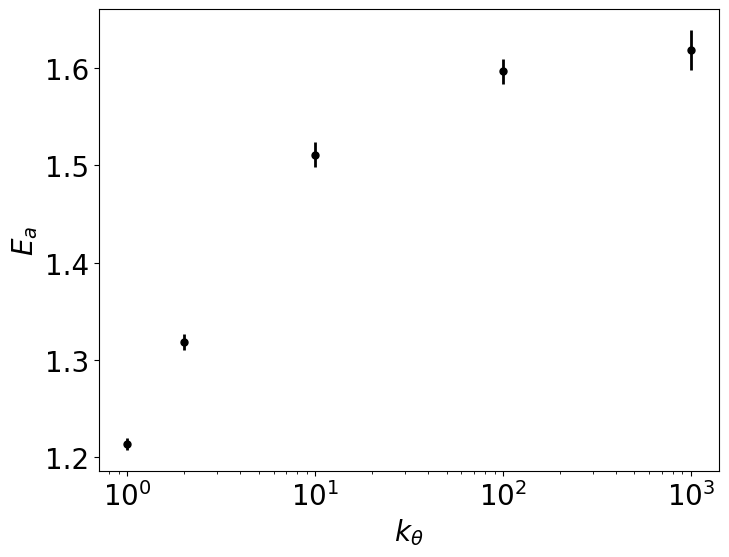

In [56]:
# create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (8,6))
plt.xlabel(r'$k_\theta$')
plt.ylabel(r'$E_a$')
plt.xscale('log')

x = np.array([1,2,10,100, 1000])
y = -np.array(slopes)
yerr = np.array(errors)
axs.errorbar(y=y, yerr=yerr, x=x, fmt='.', markersize=10, linewidth=2, color='k')

plt.savefig('/home/alena.taskina01/Pictures/Ea_D.svg')

9.993290472441706e-08
1.3318790355591142e-08
7.3327935707698126e-09
1.9323097275091904e-08
9.70195350025436e-09


/tmp/ipykernel_2366021/24499171.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


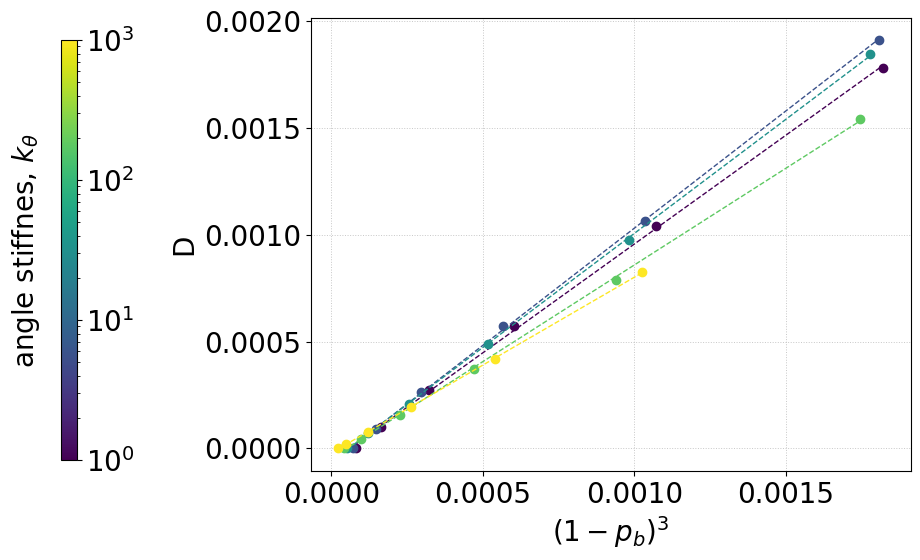

In [52]:
#create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (8,6))
axs.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)
plt.xlabel(r'$(1-p_b)^3$')
plt.ylabel(r'D')

# create a colorbar
colors = plt.cm.viridis(np.linspace(0, 1, 5))
norm = mcolors.LogNorm(vmin=1, vmax=1000)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar_ax = f.add_axes([-0.1, 0.2, 0.02, 0.7]) 
cbar = f.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'angle stiffnes, $k_\theta$', rotation=90, labelpad=-90)

N=10648
slopes = []
errors = []

kTs = np.array([np.round(0.06+i*0.002,3) for i in range(6)])
x = 1/kTs
pairs_data = [pairs, pairs_k1, pairs_k2, pairs_k10, pairs_k100, pairs_k1000]

for j in range(5): #loop over angle stiffness
    #plot the data
    x = np.array([(np.mean(pairs_data[j+1][kT][0]/(N*3)))**3 for kT in kTs])
    y = np.array([Ds[j+1][str(kT)] for kT in kTs])
    y -= y[0]
    axs.plot(x, y, 'o', label=r'$k_\theta=1$', color=colors[j])
    #fit the data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(p_value)
    slopes.append(slope)
    errors.append(std_err)
    axs.plot(x, slope * x + intercept, linestyle='--', color=colors[j], linewidth=1)

f.tight_layout()

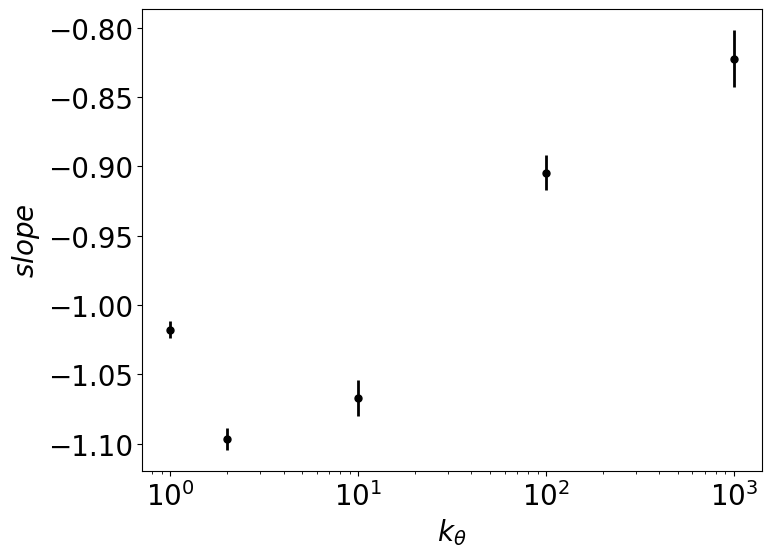

In [54]:
# create a figure
mpl.rcParams['font.size'] = 20
f, axs = plt.subplots(1, 1, figsize = (8,6))
plt.xlabel(r'$k_\theta$')
plt.ylabel(r'$slope$')
plt.xscale('log')

x = np.array([1,2,10,100, 1000])
y = -np.array(slopes)
yerr = np.array(errors)
axs.errorbar(y=y, yerr=yerr, x=x, fmt='.', markersize=10, linewidth=2, color='k')